## Convolutions

The goal of this part is make the neural network convolutional.

In [29]:
# These are all the modules I'll be using later. 
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import pandas as pd
import urllib
import cPickle as pickle
from PIL import Image
import scipy.io as sio
import scipy.io
import h5py
import random
import tensorflow as tf
from sklearn.cross_validation import train_test_split as ttsplit
import math as math
import pylab as P
%matplotlib inline

In [30]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (230540, 32, 32, 1) (230540, 6)
Validation set (5214, 32, 32, 1) (5214, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [31]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels)) / labels.size

Let's build a network with convolutional layers, followed by one fully connected layer. 

Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.


In [32]:
batch_size = 64
patch_size = 5
image_size = 32
label_size = 6
num_channels = 1 # gray scale
num_labels = 11
depth = 16
num_hidden = 64
keep_prob = 0.5

In [33]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, label_size))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
   ## 5 x 5 x 1 x 16 -> 28 x 28 x 1 x 16
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
    
  ## 5 x 5 x 16 x 16 -> 24 x 24 x 16 x 16
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

  layer3_weights = tf.Variable(tf.truncated_normal([patch_size * patch_size * depth, num_hidden], stddev=0.1)) 
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  ## create 5 predictors here for the five places
  
  op1_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  op1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  op2_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  op2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  op3_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  op3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  op4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  op4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  op5_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  op5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))


  # Model.
  def model(data, is_training = False):
    # First Convolutional Layer with Pooling
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    pool = tf.nn.avg_pool(conv, [1, 4, 4, 1], [1,2,2,1], padding = 'SAME')
    hidden = tf.nn.relu(pool + layer1_biases)
    
    # Second Convolutional Layer with Pooling
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='VALID')
    pool = tf.nn.max_pool(conv, [1,1,1,1], [1,1,1,1], padding = 'SAME')
    hidden = tf.nn.relu(pool + layer2_biases)
    
    # Fully Connected Layer
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    if is_training:
        hidden  = tf.nn.dropout(hidden, keep_prob)

    digit_1 = tf.matmul(hidden, op1_weights) + op1_biases
    digit_2 = tf.matmul(hidden, op2_weights) + op2_biases
    digit_3 = tf.matmul(hidden, op3_weights) + op3_biases
    digit_4 = tf.matmul(hidden, op4_weights) + op4_biases
    digit_5 = tf.matmul(hidden, op5_weights) + op5_biases
    
    return (digit_1, digit_2, digit_3, digit_4, digit_5)

  
  # Training computation.
  d1, d2, d3, d4, d5 = model(tf_train_dataset, True)
    
  # Loss function
  loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(d1, tf_train_labels[:,1])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d2, tf_train_labels[:,2])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d3, tf_train_labels[:,3])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d4, tf_train_labels[:,4])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d5, tf_train_labels[:,5])
    )
    
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.15, global_step, 1000, 0.96)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(d) for d in [d1, d2, d3, d4, d5]])
  valid_model  = model(tf_valid_dataset)
  valid_prediction = tf.pack([tf.nn.softmax(valid_model[idx]) for idx in range(5)]) #d in [valid_model]])
  test_model  = model(tf_test_dataset)
  test_prediction = tf.pack([tf.nn.softmax(test_model[idx]) for idx in range(5)])


In [34]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels[:,1:6]))
  final_predictions = test_prediction.eval()
  print('Test accuracy: %.1f%%' % accuracy(final_predictions, test_labels[:,1:6]))

Initialized
Minibatch loss at step 0: 18.349255
Minibatch accuracy: 9.4%
Validation accuracy: 59.9%
Minibatch loss at step 1000: 5.304308
Minibatch accuracy: 61.9%
Validation accuracy: 69.6%
Minibatch loss at step 2000: 4.826167
Minibatch accuracy: 69.1%
Validation accuracy: 75.9%
Minibatch loss at step 3000: 4.475911
Minibatch accuracy: 67.8%
Validation accuracy: 77.4%
Minibatch loss at step 4000: 4.215043
Minibatch accuracy: 73.8%
Validation accuracy: 79.0%
Minibatch loss at step 5000: 4.098014
Minibatch accuracy: 73.1%
Validation accuracy: 80.4%
Minibatch loss at step 6000: 3.515169
Minibatch accuracy: 75.3%
Validation accuracy: 82.9%
Minibatch loss at step 7000: 3.902353
Minibatch accuracy: 75.6%
Validation accuracy: 83.2%
Minibatch loss at step 8000: 3.268173
Minibatch accuracy: 78.8%
Validation accuracy: 83.0%
Minibatch loss at step 9000: 3.195396
Minibatch accuracy: 77.8%
Validation accuracy: 83.9%
Minibatch loss at step 10000: 3.218955
Minibatch accuracy: 79.1%
Validation accur

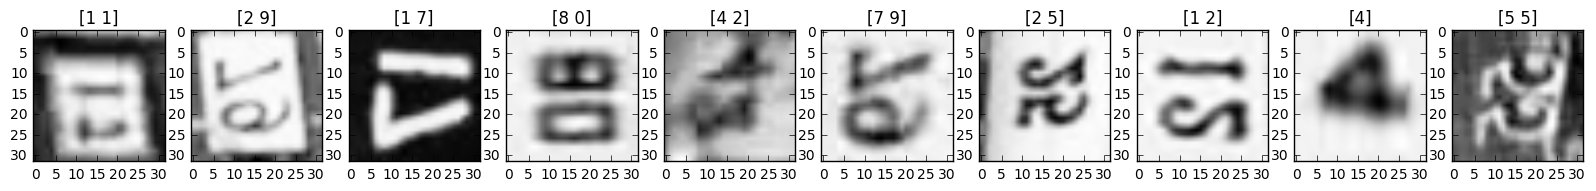

In [41]:
predictions = np.argmax(final_predictions, 2).T

display_size = 10
fig = P.figure(figsize=(20, 20))
rand_indices = np.random.randint(0, test_dataset.shape[0], display_size)

for x in range(len(rand_indices)):
    idx = rand_indices[x]
    a = fig.add_subplot(1, display_size, x+1)
    
    P.imshow(test_dataset[idx,:,:,0].T, cmap='Greys_r')
    img_prediction  = predictions[idx,:]
    a.set_title(str(img_prediction[img_prediction != 10]))